# Segmentation

In [2]:
import sys, os
sys.path.append('../')

import tensorflow as tf 

from MRIsegm.datagenerators import create_segmentation_generator
from MRIsegm.metrics import dice_coef
from MRIsegm.losses import DiceBCEloss
from MRIsegm.models import unet
from MRIsegm.graphics import show_dataset, plot_history, show_prediction

## Constants

In [3]:
SEED = 666
BATCH_SIZE_TRAIN = 8
BATCH_SIZE_VALIDATION = 8

IMAGE_HEIGHT = 128
IMAGE_WIDTH =  128
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

NUM_OF_EPOCHS = 100

NUM_TRAIN = 406
NUM_VALIDATION = 80

EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_VALIDATION = NUM_VALIDATION // BATCH_SIZE_VALIDATION

data_dir_training = '../data/training'
data_dir_train_img = os.path.join(data_dir_training, 'img')
data_dir_train_mask = os.path.join(data_dir_training, 'mask')

data_dir_validation = '../data/validation'
data_dir_validation_img = os.path.join(data_dir_validation, 'img')
data_dir_validation_mask = os.path.join(data_dir_validation, 'mask')


## Generators

In [4]:
data_gen_args_img = dict(rescale=1./255, rotation_range=5,horizontal_flip=True)
data_gen_args_mask = dict(rescale=1./255, rotation_range=5,horizontal_flip=True)

val_data_gen_args_img = dict(rescale=1./255)
val_data_gen_args_mask = dict(rescale=1./255)

In [5]:
train_generator = create_segmentation_generator(data_dir_train_img, data_dir_train_mask, BATCH_SIZE_TRAIN, IMG_SIZE, SEED, data_gen_args_img, data_gen_args_mask)

validation_generator = create_segmentation_generator(data_dir_validation_img, data_dir_validation_mask, BATCH_SIZE_VALIDATION, IMG_SIZE, SEED, val_data_gen_args_img, val_data_gen_args_mask)

Found 406 images belonging to 1 classes.
Found 406 images belonging to 1 classes.
Found 80 images belonging to 1 classes.
Found 80 images belonging to 1 classes.


### Show trainig data

In [ ]:
show_dataset(train_generator, 3) # training

### Show validation data

In [ ]:
show_dataset(validation_generator, 3) # validation

## Model

In [6]:
model = unet(IMAGE_HEIGHT, IMAGE_WIDTH, n_levels=5, initial_features=32)

optimizer = 'adam'
loss = DiceBCEloss
metrics = [  dice_coef ]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.summary()

Model: "UNET-L5-F32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________________

In [7]:
model_name = model.name + f'_{IMAGE_HEIGHT}_{IMAGE_WIDTH}' 


if type(optimizer) == str: 
    model_name = model_name + f'_OPT={optimizer}' 
else:
    model_name = model_name + f'_OPT={optimizer._name}'


if type(loss) == str: 
    model_name = model_name + f'_LOSS={loss}' 
else:
    model_name = model_name + f'_LOSS={loss.__name__}'

print('model name: ', model_name)

model name:  UNET-L5-F32_128_128_OPT=adam_LOSS=DiceBCEloss


In [8]:
# optional: logs_dir = '../data/models/logs/model_name'
# optional: csv_dir = '../data/CSV/'

callbacks = [
                  # optional: tf.keras.callbacks.ModelCheckpoint('../data/models/checkpoints/' + model_name + '_checkpoint' + '.h5', save_best_only=True),
                  # optional: tf.keras.callbacks.CSVLogger( csv_dir + model_name + '.csv', separator=',', append=False),
                  tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')
                  # optional: tf.keras.callbacks.TensorBoard(log_dir=logs_dir)
]

history = model.fit(train_generator,
            steps_per_epoch=EPOCH_STEP_TRAIN, 
            validation_data=validation_generator, 
            validation_steps=EPOCH_STEP_VALIDATION,
            epochs=NUM_OF_EPOCHS,
            callbacks=callbacks)

Epoch 1/100
50/50 [==============================] - 13s 234ms/step - loss: 0.9689 - dice_coef: 0.1205 - val_loss: 7.5463 - val_dice_coef: 7.5211e-04
Epoch 2/100
50/50 [==============================] - 11s 230ms/step - loss: 0.7711 - dice_coef: 0.2772 - val_loss: 4.6778 - val_dice_coef: 0.0012
Epoch 3/100
50/50 [==============================] - 11s 230ms/step - loss: 0.6980 - dice_coef: 0.3549 - val_loss: 2.2013 - val_dice_coef: 9.6250e-04
Epoch 4/100
50/50 [==============================] - 11s 230ms/step - loss: 0.6114 - dice_coef: 0.4353 - val_loss: 1.1538 - val_dice_coef: 0.0094
Epoch 5/100
50/50 [==============================] - 11s 230ms/step - loss: 0.5604 - dice_coef: 0.4827 - val_loss: 1.3006 - val_dice_coef: 0.0083
Epoch 6/100
50/50 [==============================] - 11s 230ms/step - loss: 0.5560 - dice_coef: 0.4858 - val_loss: 1.0132 - val_dice_coef: 0.2501
Epoch 7/100
50/50 [==============================] - 11s 230ms/step - loss: 0.5304 - dice_coef: 0.5084 - val_loss: 0

In [14]:
model.save('../data/models/' + model_name + '.h5')

In [ ]:
# optional: %load_ext tensorboard

# optional: !tensorboard --logdir log_dir

In [9]:
print("Evaluating on validation data")
evaluation = model.evaluate(validation_generator, batch_size=BATCH_SIZE_VALIDATION, steps=EPOCH_STEP_VALIDATION, return_dict=True)
print(evaluation)

Evaluating on validation data
10/10 [==============================] - 1s 65ms/step - loss: 0.3905 - dice_coef: 0.6475
{'loss': 0.39046651124954224, 'dice_coef': 0.6474500298500061}


In [10]:
import json

with open('../data/evals/' + model_name + '_eval.txt', 'w') as file:
     file.write(json.dumps(evaluation))

## Plots

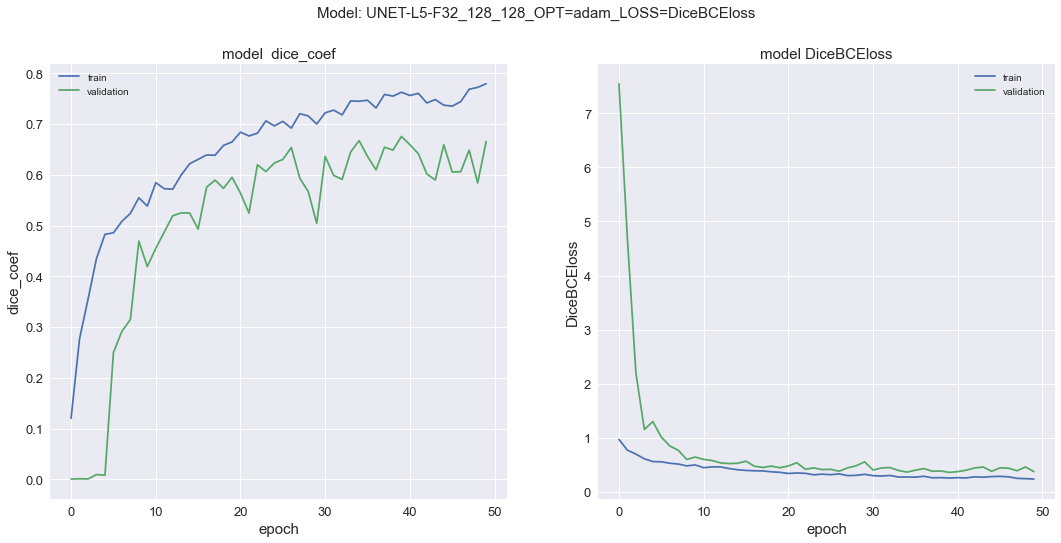

In [11]:
plot_history(model_name, history, metrics, loss, custom_loss=True, custom_metrics=True, figsize=(18,8),labelsize=13, path='../data/plots/' + model_name)

## Predictions

### Training images prediction

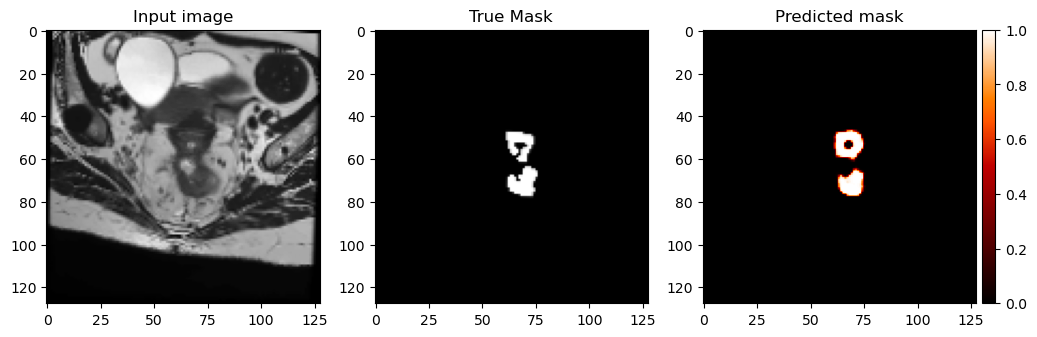

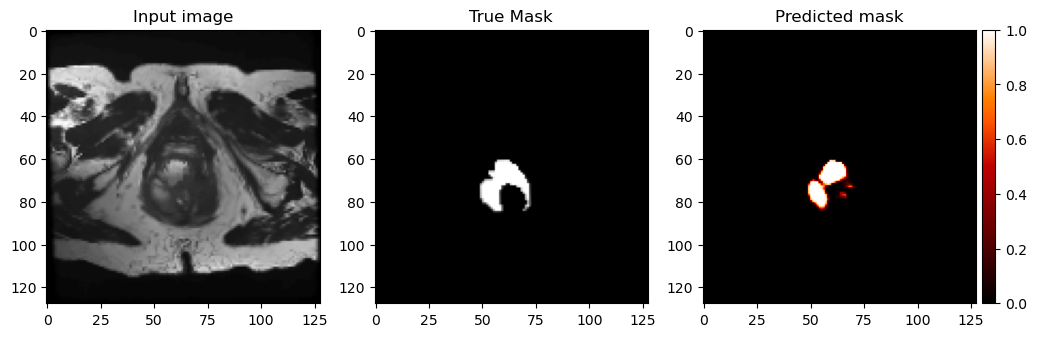

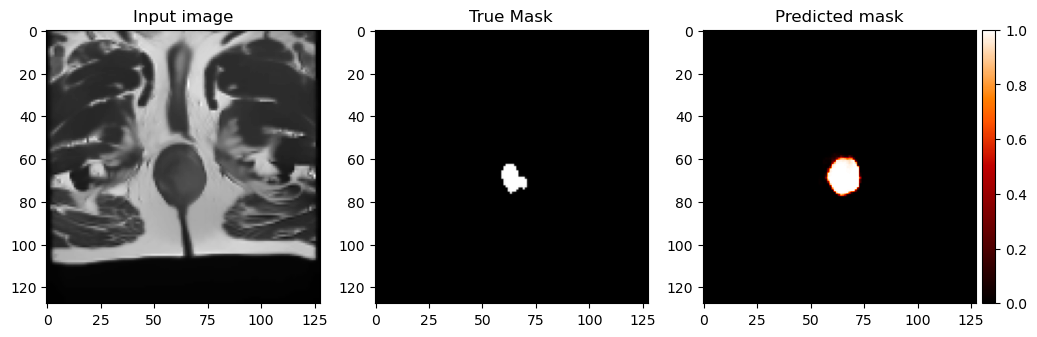

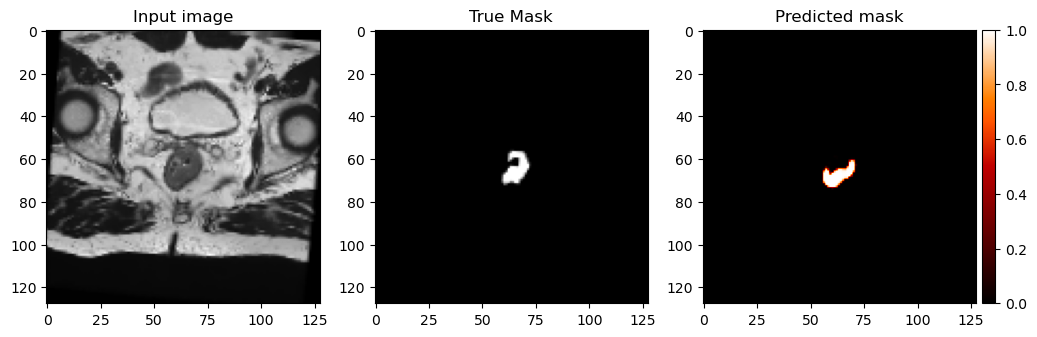

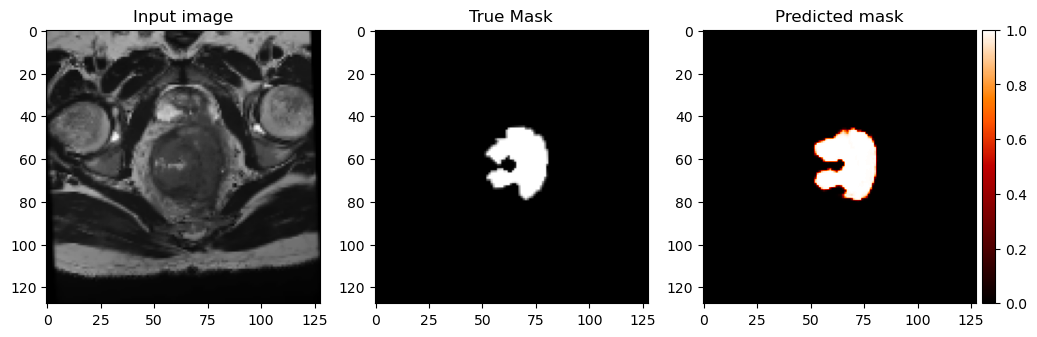

In [12]:
show_prediction(datagen=train_generator, model=model , num=5)

### Validation images prediction

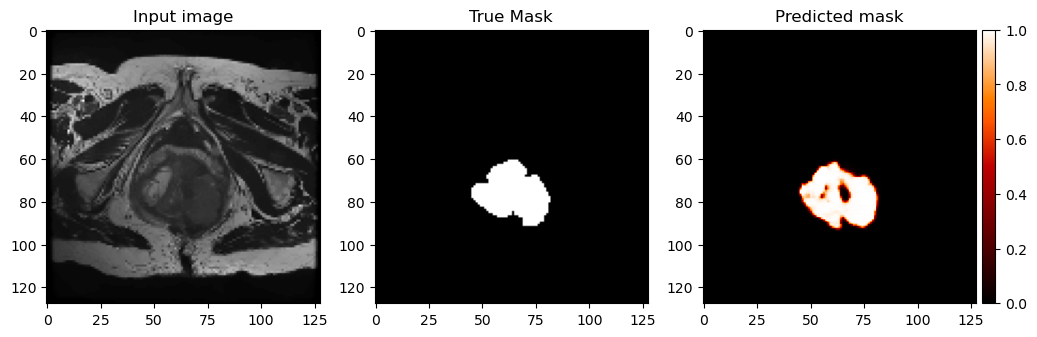

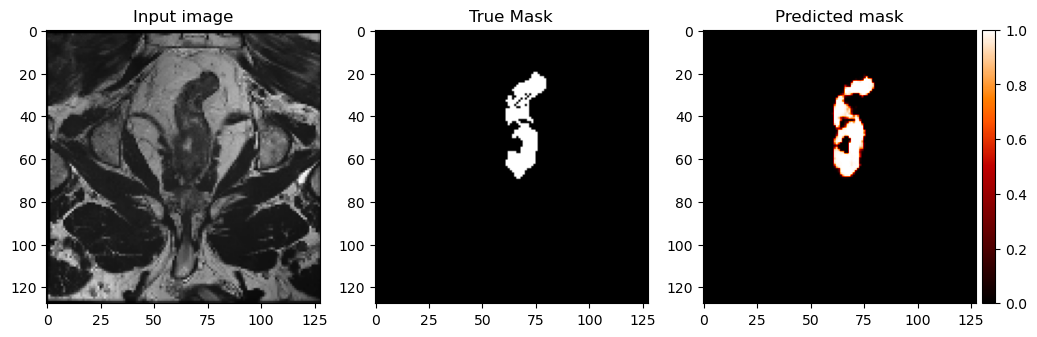

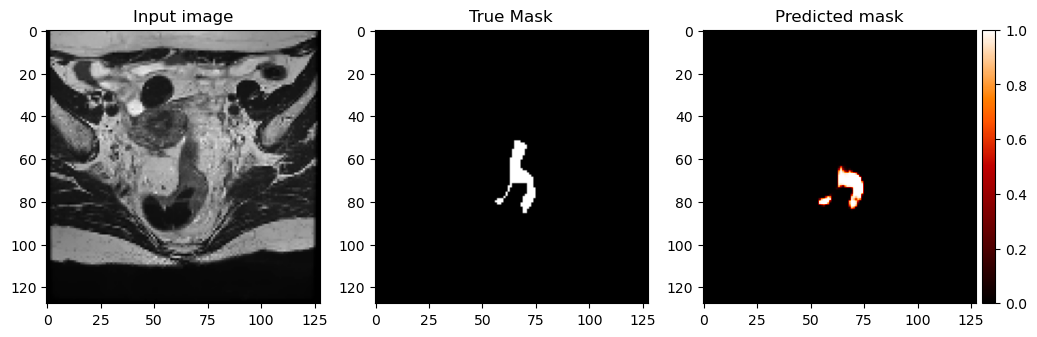

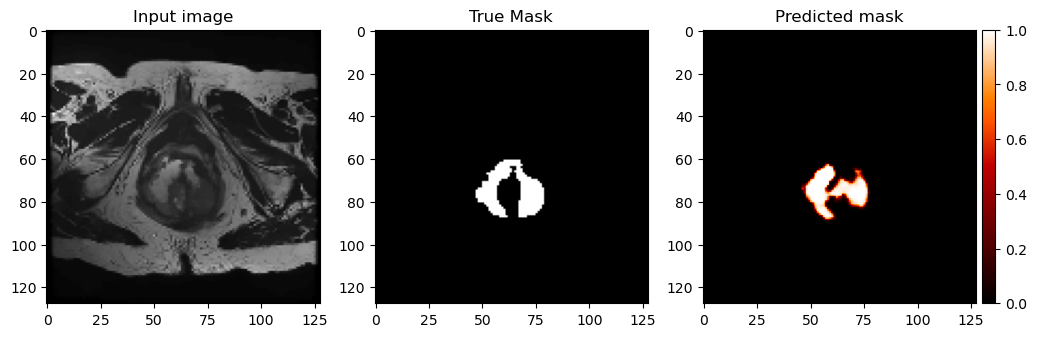

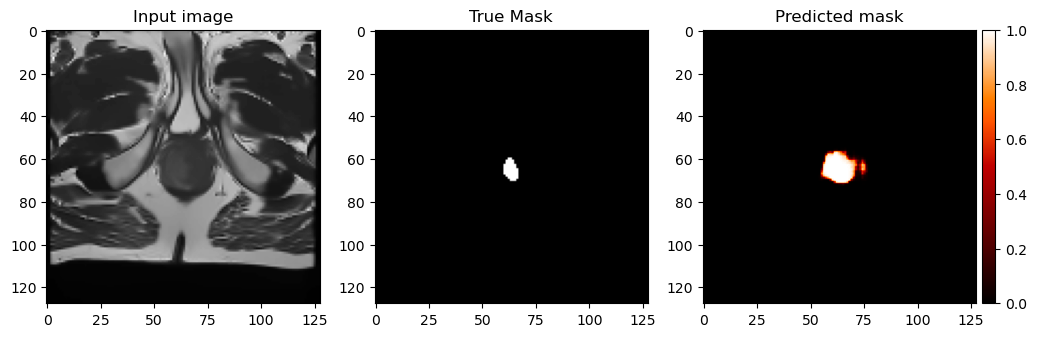

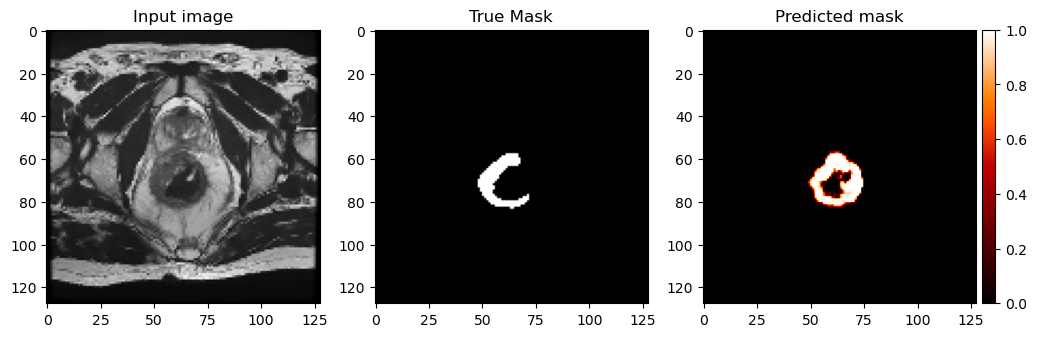

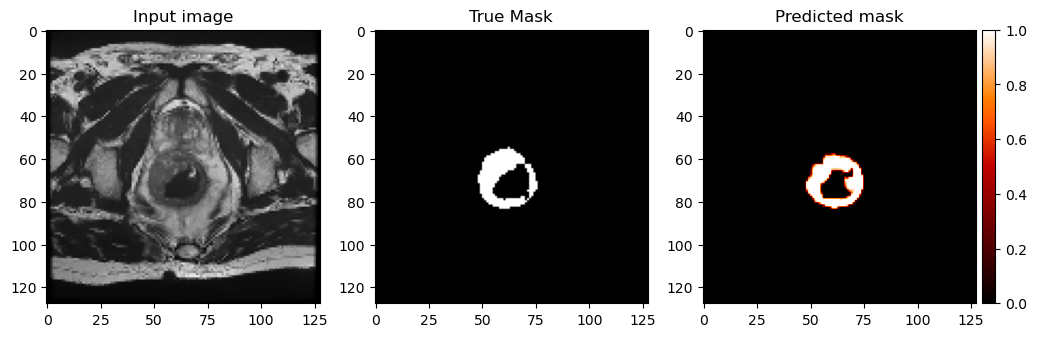

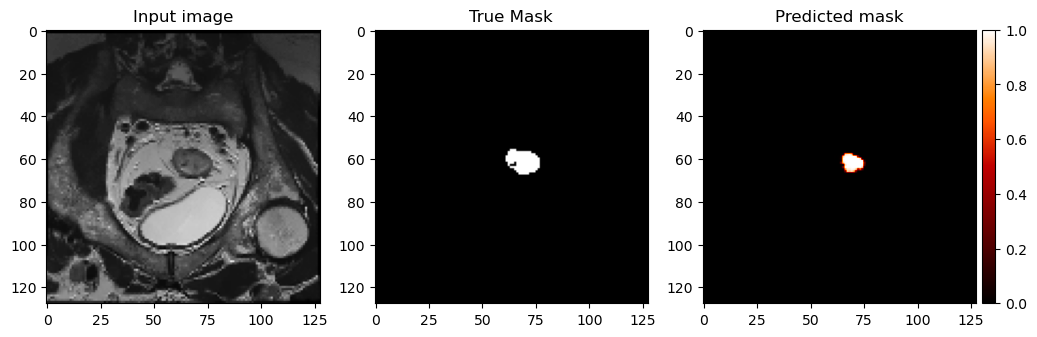

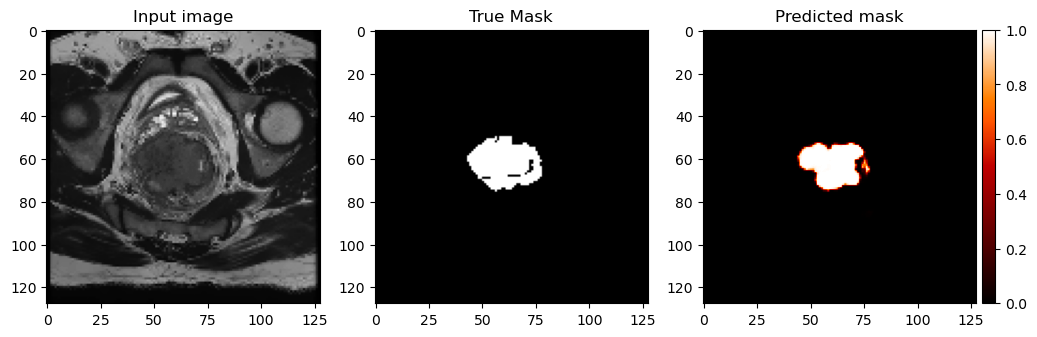

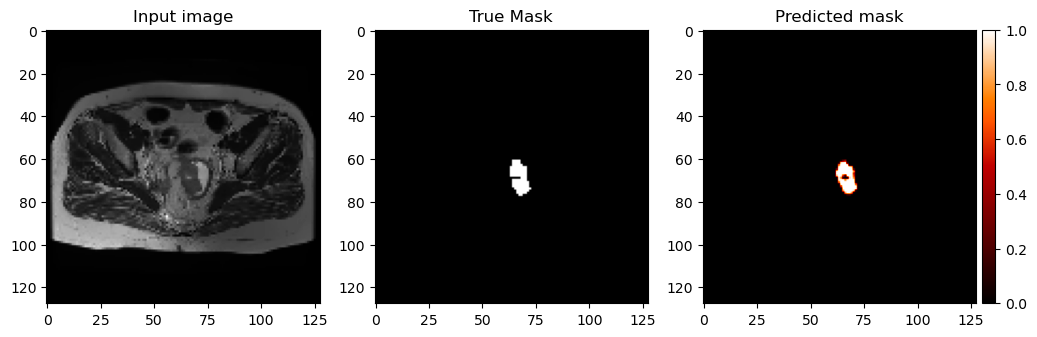

In [13]:
show_prediction(datagen=validation_generator, model=model , num=10)